## Normal Setup

Perform a normal setup as you otherwise would. Adjust the platform & target as needed. Here we'll attack an XMEGA device on the CW308 UFO board for example. Note that because the UFO boards are missing the decoupling capacitors & have a resistive shunt, you may find they perform *worse* for H-Field probe usage than normal development kits.

Neverless, we're going to give it a shot! We found the XMEGA works better than the STM32F3 target on the UFO board, so we'll do this tutorial with the XMEGA target board.

In [1]:
 %load_ext autotime

SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'
CRYPTO_TARGET = 'TINYAES128C'
num_traces = 500
CHECK_CORR = False

time: 331 µs (started: 2022-04-08 11:04:04 -04:00)


In [2]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd /home/ucsec/chipwhisperer/hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2

Building for platform CWLITEXMEGA with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
make clean_objs .dep 
make[1]: Entering directory '/home/ucsec/chipwhisperer/hardware/victims/firmware/simpleserial-aes'
Building for platform CWLITEXMEGA with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
rm -f -- simpleserial-aes-CWLITEXMEGA.hex
rm -f -- simpleserial-aes-CWLITEXMEGA.eep
rm -f -- simpleserial-aes-CWLITEXMEGA.cof
rm -f -- simpleserial-aes-CWLITEXMEGA.elf
rm -f -- simpleserial-aes-CWLITEXMEGA.map
rm -f -- simpleserial-aes-CWLITEXMEGA.sym
rm -f -- simpleserial-aes-CWLITEXMEGA.lss
rm -f -- objdir-CWLITEXMEGA/*.o
rm -f -- objdir-CWLITEXMEGA/*.lst
rm -f -- simpleserial-aes.s simpleserial.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s aes.s aes-independant.s
rm -f -- simpleserial-aes.d simpleserial.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d aes.d aes-independant.d
rm -f -- simple

In [3]:
%run "/home/ucsec/hl/chipwhisperer-jupyter/Setup_Scripts/Setup_Generic.ipynb"

See https://chipwhisperer.readthedocs.io/en/latest/api.html#firmware-update


INFO: Found ChipWhisperer😍
time: 890 ms (started: 2022-04-08 11:04:05 -04:00)


In [4]:
fw_path = '/home/ucsec/chipwhisperer/hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex'.format(PLATFORM)

time: 456 µs (started: 2022-04-08 11:04:06 -04:00)


In [5]:
cw.program_target(scope, prog, fw_path)

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 4263 bytes
time: 704 ms (started: 2022-04-08 11:04:06 -04:00)


In [6]:
scope.gain.gain = 70

time: 2.46 ms (started: 2022-04-08 11:04:06 -04:00)


## Visual Capture Loop

Now adjusting the H-Field probe around, you can find an interesting location. The following loop will run up to 5000 captures, but throws them away. Just stop the loop if you find a good physical location (traces look stable). This might not be super-obvious: you'll see how to run a CPA attack next.

## Actual Capture Loop & Analysis

Then run the following two blocks - if the results aren't good, try another location!

In [7]:
import numpy as np
import chipwhisperer as cw
import chipwhisperer.analyzer as cwa

#project = cw.create_project("projects/hfield_demo.cwp", overwrite = True)

from tqdm import tnrange
ktp = cw.ktp.Basic()

## define val to store data (trace,text,key)
power_trace, plain_text = [],[]

for i in tnrange(num_traces, desc='Capturing traces'):
    key, text = ktp.next()  # manual creation of a key, text pair can be substituted here
    
    trace = cw.capture_trace(scope, target, text, key)
    if trace is None:
        continue
    
    power_trace.append(np.array(trace[0]))
    plain_text.append(np.array(trace[1]))

key = key  ## as key in all iterations are the same

/tmp/ipykernel_144378/3473957045.py:13: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(num_traces, desc='Capturing traces'):


Capturing traces:   0%|          | 0/500 [00:00<?, ?it/s]

time: 14.2 s (started: 2022-04-08 11:04:06 -04:00)


In [8]:
## save the results into npz file
import numpy as np
import os

output_path = './results/em_trace_capture/'
os.makedirs(output_path,exist_ok=True)

np.savez(os.path.join(output_path,'trace_plaintext_key.npz'),power_trace=power_trace,plain_text=plain_text,key=key)
print(f"shape of power trace {np.array(power_trace).shape}")
print(f"shape of plain text {np.array(plain_text).shape}")
print(f"shape of key {np.array(key).shape}")
print(f"Data saved successfully in {os.path.join(output_path,'trace_plaintext_key.npz')}!")

shape of power trace (500, 5000)
shape of plain text (500, 16)
shape of key (16,)
Data saved successfully in ./results/em_trace_capture/trace_plaintext_key.npz!
time: 87 ms (started: 2022-04-08 11:04:20 -04:00)


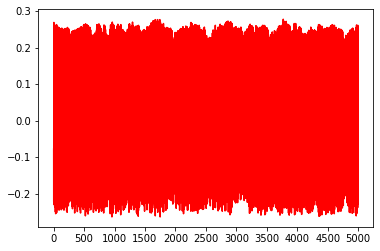

time: 239 ms (started: 2022-04-08 11:05:12 -04:00)


In [11]:
## plot the last trace 

%matplotlib notebook
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.pyplot import MultipleLocator

x_locator = MultipleLocator(500)
ax = plt.gca()
ax.xaxis.set_major_locator(x_locator)

plt.plot(power_trace[-1], color='r')

In [10]:
## disconnect device
scope.dis()
target.dis()

time: 828 µs (started: 2022-04-08 11:04:21 -04:00)
